In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import os
from Adaboost import Adaboost
import scipy.stats
% matplotlib inline

In [4]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

MONTH_MARK =pd.Timestamp('2000-01-01')
close = pd.read_csv('../SimulateTradeData/data/CLOSE.csv').set_index('Times')
close.index = pd.to_datetime(close.index)
close['month_num'] = [diff_month(x, MONTH_MARK) for x in close.index]
daily_rtn = close.drop('month_num', axis=1).pct_change()
daily_rtn['month_num'] = close.month_num.values

In [5]:
factors = ['CASHFLOW_TTM', 'EPS_TTM', 'MKT_CAP_ASHARE2', 'MKT_CAP_FLOAT', 'MKT_FREESHARES',
           'PB', 'PCF_OCF_TTM', 'PE_TTM', 'ROA_TTM', 'ROE_TTM', 'TURN']

factor_panel = dict()
for factor in factors:
    factor_df = pd.read_csv(os.path.join('../SimulateTradeData/data/', factor + '.csv'))
    factor_df.Times = pd.to_datetime(factor_df.Times)
    factor_df['month_num'] = [diff_month(x, MONTH_MARK)for x in factor_df.Times]
    factor_df = factor_df.set_index('month_num')
    factor_panel[factor] = factor_df
factor_panel = pd.Panel(factor_panel)

In [6]:
rtn = close.resample('M', closed='right', label='left').first().pct_change()
rtn['month_num'] = [diff_month(x, MONTH_MARK)for x in rtn.index]

In [7]:
# 144
to_buy_each_month = dict()
for current_month in range(144, 144+13):
    cond = (rtn['month_num'] < current_month) & (rtn['month_num'] >= current_month - 12)
    training_period_months = rtn[cond]['month_num']
    train_data = []

    for month in training_period_months:
        monthly_perf = rtn[rtn.month_num == month].ix[0].drop('month_num')

        outperformers = monthly_perf[monthly_perf > monthly_perf.dropna().quantile(0.7)]
        underperformers = monthly_perf[monthly_perf < monthly_perf.dropna().quantile(0.3)]

        # notice that we need to use month - 1 because we are using the last month X to predict this month Y
        monthly_outperf_factors = factor_panel[:,month - 1,outperformers.index]
        monthly_underperf_factors = factor_panel[:,month - 1,underperformers.index]
        monthly_factors = pd.concat([monthly_outperf_factors, monthly_underperf_factors])

        monthly_y = [1 for _ in range(len(outperformers))] + [-1 for _ in range(len(underperformers))]

        monthly_train_data = monthly_factors.copy()
        monthly_train_data['y'] = monthly_y
    
        train_data.append(monthly_train_data)
    
    train_data = pd.concat(train_data)
    
    X1 = train_data[factors]
    X1 = X1.fillna(X1.mean())
    y1 = train_data.y.values
    X1 = Adaboost.normalize_factor(X1)
    
    # last month training data
    month = current_month - 1
    monthly_perf = rtn[rtn.month_num == month].ix[0].drop('month_num')
    outperformers = monthly_perf[monthly_perf > monthly_perf.dropna().quantile(0.7)]
    underperformers = monthly_perf[monthly_perf < monthly_perf.dropna().quantile(0.3)]

    # notice that we need to use month - 1 because we are using the last month X to predict this month Y
    monthly_outperf_factors = factor_panel[:,month - 1,outperformers.index]
    monthly_underperf_factors = factor_panel[:,month - 1,underperformers.index]
    monthly_factors = pd.concat([monthly_outperf_factors, monthly_underperf_factors])

    monthly_y = [1 for _ in range(len(outperformers))] + [-1 for _ in range(len(underperformers))]

    monthly_train_data = monthly_factors.copy()
    monthly_train_data['y'] = monthly_y

    X2 = monthly_train_data[factors]
    X2 = X2.fillna(X2.mean())
    y2 = monthly_train_data.y.values
    X2 = Adaboost.normalize_factor(X2)
    
    
    
    ada_long = Adaboost.Adaboost()
    ada_short = Adaboost.Adaboost()
    eAda = Adaboost.enhancedAda([ada_long, ada_short])
    eAda.fit((X1, y1), (X2, y2))

    y_test = rtn[rtn.month_num == current_month].ix[0].drop('month_num').dropna()
    X_test = factor_panel[:,current_month - 1, y_test.index]
    X_test = Adaboost.normalize_factor(X_test)

    predictions = eAda.predict(X_test)


    to_buy = y_test.index[predictions > np.percentile(predictions, 95)]
    # returns_each_month = rtn[rtn.month_num == current_month][to_buy].mean(axis=1)
    to_buy_each_month[current_month] = to_buy
    print(current_month)

144
145
146
147
148
149
150
151
152
153
154
155
156


In [37]:
# 144
to_buy_each_month = dict()
for current_month in range(144, 212):
    cond = (rtn['month_num'] < current_month) & (rtn['month_num'] >= current_month - 12)
    training_period_months = rtn[cond]['month_num']

    ada_clfs = []
    for month in training_period_months:
        monthly_perf = rtn[rtn.month_num == month].ix[0].drop('month_num')

        outperformers = monthly_perf[monthly_perf > monthly_perf.dropna().quantile(0.7)]
        underperformers = monthly_perf[monthly_perf < monthly_perf.dropna().quantile(0.3)]

        # notice that we need to use month - 1 because we are using the last month X to predict this month Y
        monthly_outperf_factors = factor_panel[:,month - 1,outperformers.index]
        monthly_underperf_factors = factor_panel[:,month - 1,underperformers.index]
        monthly_factors = pd.concat([monthly_outperf_factors, monthly_underperf_factors])

        monthly_y = [1 for _ in range(len(outperformers))] + [-1 for _ in range(len(underperformers))]

        monthly_train_data = monthly_factors.copy()
        monthly_train_data['y'] = monthly_y


        X = monthly_train_data[factors]
        X = X.fillna(X.mean())
        X = Adaboost.normalize_factor(X)
        y = monthly_train_data.y.values
        
        ada = Adaboost.Adaboost()
        ada.fit(X, y)
        ada_clfs.append(ada)
    
    predictions = []
    
    
    y_test = rtn[rtn.month_num == current_month].ix[0].drop('month_num').dropna()
    X_test = factor_panel[:,current_month - 1, y_test.index]
    X_test = Adaboost.normalize_factor(X_test)
    
    predictions = np.zeros(len(y_test))
    for i, ada in enumerate(ada_clfs):
        predictions += 1/len(ada_clfs) * ada.predict(X_test)


    to_buy = y_test.index[predictions > np.percentile(predictions, 95)]
    # returns_each_month = rtn[rtn.month_num == current_month][to_buy].mean(axis=1)
    to_buy_each_month[current_month] = to_buy
    print(current_month)

144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211


In [38]:
last_market_info = None
first = True
res = []
transaction_cost = 0.5 / 100
for i, month in enumerate(to_buy_each_month):
    to_buy = to_buy_each_month[month]        
    market_info = close[close.month_num == month][to_buy].pct_change().mean(axis=1).copy()
    if first:
        first = False
    else:
        reb_pnl = daily_rtn.ix[market_info.index[0]][last_to_buy].mean() - transaction_cost
        market_info.ix[0] = reb_pnl
    last_to_buy = to_buy
    res.append(market_info)

In [39]:
res = pd.concat(res)

In [45]:
res

2012-01-04         NaN
2012-01-05   -0.035515
2012-01-06    0.005657
2012-01-09    0.038895
2012-01-10    0.037480
2012-01-11    0.001771
2012-01-12    0.002230
2012-01-13   -0.033369
2012-01-16   -0.021549
2012-01-17    0.048491
2012-01-18   -0.013365
2012-01-19    0.009433
2012-01-20    0.011970
2012-01-30   -0.003965
2012-01-31    0.002627
2012-02-01   -0.010784
2012-02-02    0.014183
2012-02-03    0.020498
2012-02-06    0.011241
2012-02-07   -0.018287
2012-02-08    0.021765
2012-02-09    0.005036
2012-02-10    0.009488
2012-02-13    0.007073
2012-02-14    0.004608
2012-02-15    0.020251
2012-02-16    0.001297
2012-02-17   -0.006034
2012-02-20    0.000570
2012-02-21    0.008217
                ...   
2017-07-21    0.002133
2017-07-24    0.009489
2017-07-25   -0.004888
2017-07-26    0.002791
2017-07-27    0.004066
2017-07-28    0.000551
2017-07-31    0.010520
2017-08-01   -0.005342
2017-08-02   -0.006402
2017-08-03    0.003460
2017-08-04    0.000066
2017-08-07    0.006032
2017-08-08 

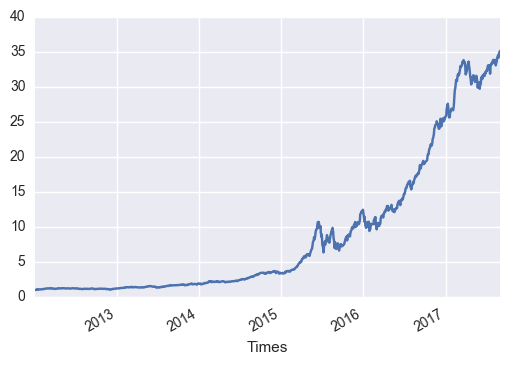

In [40]:
(1+res).cumprod().plot()

In [46]:
import tushare as ts
zz500 = ts.get_h_data('000905', start='2012-01-04', end= '2017-08-31',index=True)
zz500_rtn = zz500.sort_index().close.pct_change()
zz500_rtn.index = pd.to_datetime(zz500_rtn.index)

[Getting data:]######timed out
###<urlopen error timed out>
timed out
#############

In [41]:
res.index = res.index.date
res.index = pd.to_datetime(res.index)

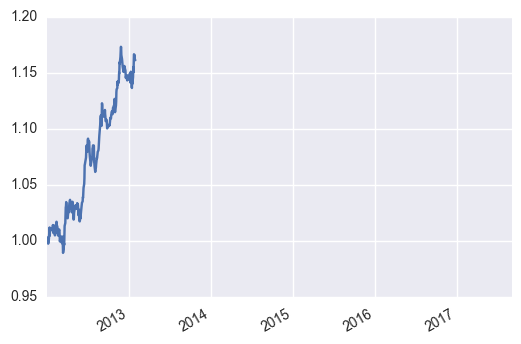

In [42]:
hedged = ((res - zz500_rtn)+1).cumprod()
hedged.plot()

In [19]:
hedged.ix[-1] / 1 - 1

0.16114331966791351